# US Federal Campaign Finance Data 1990–2016 Analysis Project

<img src="./images/us_election_finance.png" align='center'>



# <img src="./images/Data-Organisation.png" align='left' width='50'> Data Source


## Data Context

> ### This includes campaign finance data for all US federal elections (including the every-2-year congressional and every-4-year presidential) from 1990 to 2016. It includes candidate data, PAC data, individual contribution data, PAC to PAC contribution data, and PAC to candidate contribution data, along with political party, industry, sector, and geographical information for the contributions.

\.

## Data Organisation

> ### The data is available in a CSV document. It is 10 csv files for US Federal Campaign individual contributions, as shown in the below table:


|name file| size file| Description|
|-:|-:|-:|
|individual_contributions.csv|5.22GB|Individual Contributions data for all election cycle.|
|industry_codes.csv|40.72MB|The donor's industry or ideology data for individual contributions.|
|backers.csv|14.1KB|Backers' data  in election cycle.|
|candidates.csv|5.78MB| Candidates' data in election cycle.|
|committees.csv|16.95MB|Committees' data in election cycle.|
|fec_api_committees.csv|5.89MB| Updates data on committees for individual contributions for all election cycles.|
|pac_records.csv|4.4MB|PAC data in  election cycle.|
|pac_to_pacs.csv|213.95MB|PAC to PAC contribution data|
|pacs.csv|316.95MB|PAC data in Individual Contributions for election cycle.|
|politicians.csv|828.54KB|Politicians' data in election cycle.|

The dataset on Kaggle in this link: https://www.kaggle.com/datasets/jeegarmaru/campaign-contributions-19902016


# <img src="./images/business-value.png" align='left' width='50'>  Business Value

### <img src="./images/performance.png" align='left' width='50'> Since there is a very large file size (more than five gigabytes of 'individual_contributions.csv') in the US federal campaign finance data from 1990–2016, we need to design, implement, and improve the Spark application to answer some interesting questions that we should be able to answer using this dataset:

- How do individual contributions for each cycle evalve over time?
- How are contributions affected by the presidential election year vs midterms?
- How does a donor's industry or ideology affect individual contributions?

# <img src="./images/Data-Processinh.png" align='left' width='50'> Data Process

## 📥 Install required libraries

#### Before installing the library pyspark, you must execute some instructions:
1 - open terminal and run command line `start-all.sh`

2 - update bashrc by using command line `vi ~/.bashrc`

3 - Add the folowing two lines:

>  `export PYTHONPATH=$SPARK_HOME/python:$SPARK_HOME/python/lib/py4j-0.10.9-src.zip:$PYTHONPATH`

> `export PATH=$SPARK_HOME/bin:$SPARK_HOME/python:$PATH"`

4 - Hash this line

>	` # export PATH=$PATH:/home/bigdata/spark/bin`
    
5- Save the changes and exit `vi`, press the `Esc` key to ensure you are in command mode. Then type `:wq` and press `Enter`. This command will write the changes to the file and quit the editor. 

Note:  exit without saving and press esc then `:q!`

In [1]:
!pip install pyspark

  ERROR: Could not find a version that satisfies the requirement py4j==0.10.9 (from pyspark) (from versions: none)
ERROR: No matching distribution found for py4j==0.10.9 (from pyspark)


## 📥 Import libraries

In [1]:
#from pyspark import SparkContext, SparkConf
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql.functions import col, sum, count
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import broadcast
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
print(pyspark.__version__)

3.0.1


## Make Spark Config

> Increase the memory allocated to Spark: You can allocate more memory to Spark by adjusting the `spark.driver.memory` and `spark.executor.memory` configuration properties.

In [4]:
spark = SparkSession.builder.appName("US_Fed_Cam_Fin analysis").\
                                config("spark.driver.memory", "8g").\
                                config("spark.executor.memory", "8g").\
                                getOrCreate()

In [6]:
# Create a SparkConf object
conf = SparkConf()

# Get the executor memory
executor_memory = conf.get("spark.executor.memory")

# Get the driver memory
driver_memory = conf.get("spark.driver.memory")

# Print the allocated memory
print("Executor Memory:", executor_memory)
print("Driver Memory:", driver_memory)


Executor Memory: 8g
Driver Memory: 8g


> In Apache Spark, Executors are the worker nodes responsible for executing tasks in parallel. The Executor Memory refers to the amount of memory allocated to each Executor for storing data and executing tasks.

> The Driver is the program that coordinates the execution of tasks on the Executors. The Driver Memory refers to the amount of memory allocated to the Driver program for storing data and managing the overall execution.

> In this case, both the Executors and the Driver have been allocated 8 gigabytes of memory each, which means they have a total of 8 gigabytes of memory available for their respective operations.

/

## 🗃️ Load the dataset

>>We have a structured dataset in CSV format with headers and want to leverage the schema inference capabilities of Spark using <strong> SparkSession.builder.getOrCreate().read.options(header=True, inferSchema=True).csv(data)</strong> would be a suitable approach. This method reads the CSV file into a DataFrame, allowing you to perform structured operations and take advantage of Spark's optimized query execution.

In [7]:
path_folder = "./DataSet"
csv_files = [file for file in os.listdir(path_folder) if file.endswith(".csv")]
csv_files

['fec_api_committees.csv',
 'candidates.csv',
 'pacs.csv',
 'pac_records.csv',
 'politicians.csv',
 'committees.csv',
 'backers.csv',
 'pac_to_pacs.csv',
 'industry_codes.csv',
 'individual_contributions.csv']

In [8]:
def load_data(data):
    t1=time.time()
    dat = spark.read.options(header=True, inferSchema=True).csv(data)
    t2=time.time()
    print("Duration:", np.round((t2-t1), 2), "seconds")
    return(dat)

 # Create an empty dictionary
dfs_US_Fed_Cam_Fin = {} 

# read csv files in the dictionary
for name_file in csv_files:
    print(f"Loading {name_file}:")
    # Append the DataFrame to the dictionary with a file name
    dfs_US_Fed_Cam_Fin[name_file.replace(".csv","")] = load_data(path_folder+'/'+name_file)

Loading fec_api_committees.csv:
Duration: 11.88 seconds
Loading candidates.csv:
Duration: 3.85 seconds
Loading pacs.csv:
Duration: 37.49 seconds
Loading pac_records.csv:
Duration: 1.09 seconds
Loading politicians.csv:
Duration: 0.66 seconds
Loading committees.csv:
Duration: 1.39 seconds
Loading backers.csv:
Duration: 0.38 seconds
Loading pac_to_pacs.csv:
Duration: 29.41 seconds
Loading industry_codes.csv:
Duration: 0.34 seconds
Loading individual_contributions.csv:
Duration: 292.29 seconds


In [9]:
dfs_US_Fed_Cam_Fin.keys()

dict_keys(['fec_api_committees', 'candidates', 'pacs', 'pac_records', 'politicians', 'committees', 'backers', 'pac_to_pacs', 'industry_codes', 'individual_contributions'])

In [10]:
df_individual_contributions = dfs_US_Fed_Cam_Fin['individual_contributions']

##  📝Meta information of Spark Dataframe

In [11]:
print(f'the count individual_contributions: {df_individual_contributions.count()}')
print("The Schema of individual_contributions table:")
df_individual_contributions.printSchema()

the count individual_contributions: 24446421
The Schema of individual_contributions table:
root
 |-- id: string (nullable = true)
 |-- cycle: string (nullable = true)
 |-- fec_trans_id: string (nullable = true)
 |-- contributor_id: string (nullable = true)
 |-- contributor_name: string (nullable = true)
 |-- recipient_id: string (nullable = true)
 |-- org_name: string (nullable = true)
 |-- ult_org: string (nullable = true)
 |-- real_code: string (nullable = true)
 |-- date: string (nullable = true)
 |-- amount: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: string (nullable = true)
 |-- recip_code: string (nullable = true)
 |-- type: string (nullable = true)
 |-- committee_id: string (nullable = true)
 |-- other_id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- old_format_employer_occupation: string (nullable = true)
 |-- microfilm: string (nullable = true)
 |-- occ

## 🔎 Check the null values and dublicated rows

In [6]:
def get_null_count_column(df):
    for name_column in df.columns:
        print(f"Counting the null number for {name_column}:")
        t1=time.time()
        # Assuming you have a DataFrame called 'df' and a column called 'column_name'
        null_count = df.filter(col(name_column).isNull()).count()
        print(f"The null count of {name_column}: {null_count}")
        t2=time.time()
        print("Duration:", np.round((t2-t1), 2), "seconds")

In [13]:
get_null_count_column(df_individual_contributions)

The null count of id: 0
Duration: 32.34 seconds
The null count of cycle: 3
Duration: 35.65 seconds
The null count of fec_trans_id: 0
Duration: 33.97 seconds
The null count of contributor_id: 0
Duration: 34.48 seconds
The null count of contributor_name: 39834
Duration: 35.81 seconds
The null count of recipient_id: 866
Duration: 35.2 seconds
The null count of org_name: 5198237
Duration: 41.19 seconds
The null count of ult_org: 23814358
Duration: 36.29 seconds
The null count of real_code: 59
Duration: 40.41 seconds
The null count of date: 552
Duration: 35.0 seconds
The null count of amount: 47
Duration: 35.16 seconds
The null count of street: 13170692
Duration: 38.61 seconds
The null count of city: 185829
Duration: 35.49 seconds
The null count of state: 4984
Duration: 35.53 seconds
The null count of zip: 11521
Duration: 36.4 seconds
The null count of recip_code: 1027
Duration: 35.83 seconds
The null count of type: 85
Duration: 35.65 seconds
The null count of committee_id: 56
Duration: 36.

In [22]:
redundant_rows = df_individual_contributions_old.groupBy(df_individual_contributions_old.columns).count().filter(col("count") > 1)
print(redundant_rows.count())

0


### Solve the null problem, we split the dataset into two types:
1. > Individual contributions don't have The committee id number for the intermediary party to earmarked contributions.(<strong>df_ind_Unearmarked_Con</strong>)

In [9]:
df_ind_Unearmarked_Con = df_individual_contributions.filter(col("other_id").isNull()).select("*")

### <img src="./images/data-clean.png" align='left' width='50'> Data Cleaning: individual contributions data

In [10]:
# drop the useless columns that have null values ("ult_org", "other_id")
df_ind_Unearmarked_Con = df_ind_Unearmarked_Con.drop(*["ult_org", "other_id"])
# fill the null values by "unkown"
unk = "unknown"
df_ind_Unearmarked_Con = df_ind_Unearmarked_Con.fillna({"org_name":unk,
                                                        "street":unk, 
                                                        "city":unk, 
                                                        "state":unk,
                                                        "zip":unk,
                                                        "gender":"U",
                                                        "old_format_employer_occupation": unk,
                                                        "microfilm":unk,
                                                        "occupation":unk,
                                                        "employer":unk,
                                                        "source":unk})
# drop the rows with null values
df_ind_Unearmarked_Con = df_ind_Unearmarked_Con.dropna(how="any")

In [74]:
get_null_count_column(df_ind_Unearmarked_Con)

Counting the null number for id:
The null count of id: 0
Duration: 7.43 seconds
Counting the null number for cycle:
The null count of cycle: 0
Duration: 9.57 seconds
Counting the null number for fec_trans_id:
The null count of fec_trans_id: 0
Duration: 10.09 seconds
Counting the null number for contributor_id:
The null count of contributor_id: 0
Duration: 11.01 seconds
Counting the null number for contributor_name:
The null count of contributor_name: 0
Duration: 22.14 seconds
Counting the null number for recipient_id:
The null count of recipient_id: 0
Duration: 10.77 seconds
Counting the null number for org_name:
The null count of org_name: 0
Duration: 0.03 seconds
Counting the null number for real_code:
The null count of real_code: 0
Duration: 10.26 seconds
Counting the null number for date:
The null count of date: 0
Duration: 10.64 seconds
Counting the null number for amount:
The null count of amount: 0
Duration: 9.02 seconds
Counting the null number for street:
The null count of str

### Remove missing value for cycle 'X4000'
because the cycle column is Last year (even year) of the federal 2-year election cycle.

In [73]:
df_ind_Unearmarked_Con.select('cycle').distinct().show()

+-----+
|cycle|
+-----+
| 2016|
| 2012|
| 2014|
| 2000|
|X4000|
| 2002|
| 2006|
| 2004|
| 1992|
| 2008|
| 1994|
| 1996|
| 1998|
|	2006|
| 2010|
| 1990|
+-----+



In [74]:
df_ind_Unearmarked_Con.filter(col('cycle') == 'X4000').count()

3

In [11]:
df_ind_Unearmarked_Con = df_ind_Unearmarked_Con.filter(col('cycle') != 'X4000')

### Change cycle column as string type to integer type

In [26]:
df_ind_Unearmarked_Con = df_ind_Unearmarked_Con.withColumn("cycle", col("cycle").cast("integer"))

In [27]:
df_ind_Unearmarked_Con.select('cycle').distinct().show()

+-----+
|cycle|
+-----+
| 1990|
| 2006|
| 1994|
| 2014|
| 2004|
| 1996|
| 1998|
| 2012|
| 2016|
| 1992|
| 2000|
| 2010|
| 2008|
| 2002|
+-----+



2. > individual contributions have The committee id number for the intermediary party to earmarked contributions. (<strong>df_ind_Earmarked_Con</strong>)


In [12]:
df_ind_Earmarked_Con = df_individual_contributions.filter(col("other_id").isNotNull()).select("*")

### <img src="./images/data-clean.png" align='left' width='50'> Data Cleaning: individual contributions data

In [13]:
# drop the useless columns that have null values ("ult_org", "other_id")
df_ind_Earmarked_Con = df_ind_Earmarked_Con.drop(*["ult_org", "old_format_employer_occupation"])
# fill the null values by "unkown"
unk = "unknown"
df_ind_Earmarked_Con = df_ind_Earmarked_Con.fillna({"org_name":unk,
                                                    "contributor_name":unk,
                                                    "street":unk, 
                                                    "city":unk, 
                                                    "state":unk,
                                                    "zip":unk,
                                                    "gender":"U",
                                                    "occupation":unk,
                                                    "employer":unk})
# drop the rows with null values
df_ind_Earmarked_Con = df_ind_Earmarked_Con.dropna(how="any")

In [71]:
get_null_count_column(df_ind_Earmarked_Con)

Counting the null number for id:
The null count of id: 0
Duration: 7.84 seconds
Counting the null number for cycle:
The null count of cycle: 0
Duration: 8.61 seconds
Counting the null number for fec_trans_id:
The null count of fec_trans_id: 0
Duration: 8.42 seconds
Counting the null number for contributor_id:
The null count of contributor_id: 0
Duration: 7.72 seconds
Counting the null number for contributor_name:
The null count of contributor_name: 0
Duration: 0.04 seconds
Counting the null number for recipient_id:
The null count of recipient_id: 0
Duration: 9.96 seconds
Counting the null number for org_name:
The null count of org_name: 0
Duration: 0.04 seconds
Counting the null number for real_code:
The null count of real_code: 0
Duration: 10.44 seconds
Counting the null number for date:
The null count of date: 0
Duration: 10.77 seconds
Counting the null number for amount:
The null count of amount: 0
Duration: 8.89 seconds
Counting the null number for street:
The null count of street:

In [17]:
df_industry_codes = dfs_US_Fed_Cam_Fin['industry_codes']
df_industry_codes.printSchema()


root
 |-- id: integer (nullable = true)
 |-- category_code: string (nullable = true)
 |-- category_name: string (nullable = true)
 |-- industry_code: string (nullable = true)
 |-- industry_name: string (nullable = true)
 |-- sector: string (nullable = true)
 |-- sector_long: string (nullable = true)



In [19]:
get_null_count_column(df_industry_codes)

Counting the null number for id:
The null count of id: 0
Duration: 0.23 seconds
Counting the null number for category_code:
The null count of category_code: 0
Duration: 0.27 seconds
Counting the null number for category_name:
The null count of category_name: 0
Duration: 0.11 seconds
Counting the null number for industry_code:
The null count of industry_code: 0
Duration: 0.09 seconds
Counting the null number for industry_name:
The null count of industry_name: 0
Duration: 0.11 seconds
Counting the null number for sector:
The null count of sector: 0
Duration: 0.1 seconds
Counting the null number for sector_long:
The null count of sector_long: 0
Duration: 0.1 seconds


# <img src="./images/analysis.png" align='left' width='50'> Data Analysis

In [112]:
count_ind_Unearmarked_Con = df_ind_Unearmarked_Con.count()
count_ind_Earmarked_Con = df_ind_Earmarked_Con.count()

In [114]:
print(f"The count of individual contributions that don't have an intermediary party for earmarked contributions is {count_ind_Unearmarked_Con}")
print(f"The count of individual contributions that have an intermediary party for earmarked contributions is {count_ind_Earmarked_Con}")

The count of individual contributions that don't have an intermediary party for earmarked contributions is 23224559
The count of individual contributions that have an intermediary party for earmarked contributions is 1219066


## <img src="./images/Question.png" align='left' width='50'> How do individual contributions for each cycle evolve over time?

In [41]:
# The 'get_Totalamounts_groupBy' function return dataframe for total amounts by group
def get_Totalamounts_groupBy(df, name_col, number_partition = 200):
    # Partition the DataFrame by a column (e.g., "cycle")
    partitioned_df = df.repartition(number_partition, name_col)
    start_time = time.time()
    # Perform the groupBy and sum aggregation
    result_df = partitioned_df.groupBy(name_col).\
                                agg(sum("amount").alias("TotalAmount")).\
                                orderBy(col('TotalAmount').desc()).cache()
    end_time = time.time()
    # unpersist() removes the DataFrame from memory 
    # result_df.unpersist()
    # Show the result and Set `truncate` to `False` to ensure that all rows are displayed without any truncation.
    result_df.show(truncate=False)

    # Calculate the execution time
    execution_time = end_time - start_time
    print("Execution Time:", execution_time, "seconds")
    return result_df

#-----------------------------------------------------------------------------------------------------------------
# the `convert_to_k() function takes a float number as input and convert it as symbol such as 1000 into 1K
def convert_to_k(number):
    suffixes = ['', 'K', 'M', 'B', 'T']  # Add more suffixes as needed
    for suffix in suffixes:
        if abs(number) < 1000:
            return f"{number:.2f}{suffix}"
        number /= 1000
    return f"{number:.1f}T"  # If the number is larger than 1 trillion
#-----------------------------------------------------------------------------------------------------------------

# The plot_hisgram_pd function plots 
def plot_hisgram_pd(df, title, col_name1, col_name2):
    # Convert Spark DataFrame to Pandas DataFrame
    pandas_df = df.toPandas()
    # Plot histogram
    plt.figure(figsize=(14, 6))  # Set the figure size to make it larger
    plt.hist(pandas_df[col_name1],
             bins=len(pandas_df[col_name1].unique()), 
             weights=pandas_df[col_name2])
    # Add text annotations for the total amounts of each year
    for index, row in pandas_df.iterrows():
        cycle = row[col_name1]
        total_amount = row[col_name2]
        plt.text(cycle, total_amount, f'{convert_to_k(total_amount)}', ha='center', va='bottom')
    # Set the x-axis label
    plt.xlabel(col_name1)
    # Set the y-axis label
    plt.ylabel(col_name2)
    # Set the title of the histogram
    plt.title(title, fontsize=16)  
    plt.show()  # Display the histogram

### Getting the total amounts for each election cycle that doesn't have the intermediary party's earmarked contributions.

In [29]:
res_ind_unearmarked_Con = get_Totalamounts_groupBy(df_ind_Unearmarked_Con,'cycle')

+-----+-------------+
|cycle|TotalAmount  |
+-----+-------------+
|1990 |3.06008916E8 |
|1992 |6.09710988E8 |
|1994 |5.68598737E8 |
|1996 |9.97758908E8 |
|1998 |8.05928021E8 |
|2000 |1.649671649E9|
|2002 |1.470417569E9|
|2004 |2.186706549E9|
|2006 |1.525272884E9|
|2008 |3.09152343E9 |
|2010 |1.781578743E9|
|2012 |4.47612159E9 |
|2014 |2.19289553E9 |
|2016 |9.86463247E8 |
+-----+-------------+

Execution Time: 0.11927986145019531 seconds


### <img src="./images/Dataset-Exploration.png" align='left' width='50'> plotting the total amounts for each election cycle that doesn't have the intermediary party's earmarked contributions.

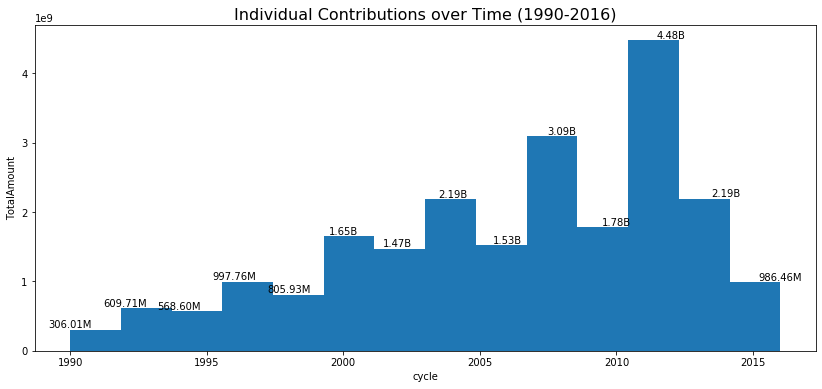

In [30]:
plot_hisgram_pd(res_ind_unearmarked_Con, 
                "Individual Contributions over Time (1990-2016)", "cycle", "TotalAmount")

### Getting the total amounts for each election cycle that has the intermediary party's earmarked contributions.

In [42]:
res_ind_Earmarked_Con = get_Totalamounts_groupBy(df_ind_Earmarked_Con, 'cycle')

+-----+------------+
|cycle|TotalAmount |
+-----+------------+
|2008 |8.83856903E8|
|2014 |3.0170596E8 |
|2012 |2.80439589E8|
|2010 |2.20395454E8|
|2000 |1.56265058E8|
|2006 |1.12603253E8|
|2004 |9.7109662E7 |
|1992 |9.4402789E7 |
|2016 |8.082593E7  |
|1996 |5.65689E7   |
|1994 |5.3031175E7 |
|2002 |4.1249503E7 |
|1998 |3.8778134E7 |
|1990 |1.8722892E7 |
+-----+------------+

Execution Time: 0.09181094169616699 seconds


###  <img src="./images/Dataset-Exploration.png" align='left' width='50'>Plotting tthe total amounts for each election cycle that has the intermediary party's earmarked contributions.

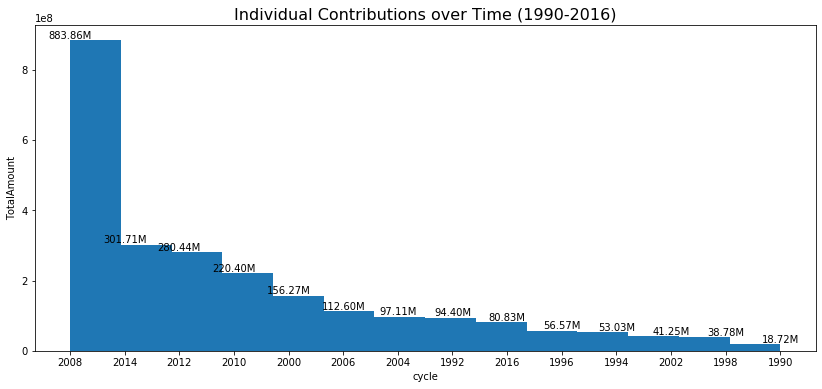

In [43]:
plot_hisgram_pd(res_ind_Earmarked_Con, 
                "Individual Contributions over Time (1990-2016)", "cycle", "TotalAmount")

## <img src="./images/Question.png" align='left' width='50'>  How are contributions affected by the presidential election year vs midterms?

In [ ]:
df_ind_Unearmarked_Con
df_ind_Earmarked_Con

In [198]:
# The 'get_Totalcount_cycle' function return dataframe for total amounts for election cycle
def get_Totalcount_cycle(df, number_partition=200):
    
    presidential_years = [1992, 1996, 2000, 2004, 2008, 2012, 2016]
    midterm_years = [1990, 1994, 1998, 2002, 2006, 2010, 2014]
    # Extract the contributions data for the years of interest, which include presidential election years and midterms
    filtered_df = df.filter(col("cycle").isin(presidential_years + midterm_years))
    
    # Partition the DataFrame by a column (e.g., "cycle")
    partitioned_df = filtered_df.repartition(number_partition, "cycle")
    
    start_time = time.time()
    
    # Perform the groupBy and sum aggregation
    # cache the intermediate result in memory, improving subsequent performance if the DataFrame is reused.
    contributions_by_year = partitioned_df.groupBy("cycle").\
                                    agg(count("*").alias("Totalcount")).\
                                    orderBy(col("cycle").asc()).cache()
    end_time = time.time()

    # Show the result and Set `truncate` to `False` to ensure that all rows are displayed without any truncation.
    contributions_by_year.show(truncate=False)

    # Calculate the execution time
    execution_time = end_time - start_time
    print("Execution Time:", execution_time, "seconds")
    return contributions_by_year

### Getting the total counts for each election cycle that doesn't have the intermediary party's earmarked contributions.

In [199]:
# using 100 partitions
contributions_by_year_Unearmarked_Con = get_Totalcount_cycle(df_ind_Unearmarked_Con,100)

+-----+----------+
|cycle|Totalcount|
+-----+----------+
|1990 |520800    |
|1992 |871908    |
|1994 |834379    |
|1996 |1218803   |
|1998 |998774    |
|2000 |1684081   |
|2002 |1412424   |
|2004 |2473264   |
|2006 |1758671   |
|2008 |3448390   |
|2010 |1989937   |
|2012 |3603287   |
|2014 |1734779   |
|2016 |675061    |
+-----+----------+

Execution Time: 0.021700620651245117 seconds


In [200]:
# using 200 partitions
contributions_by_year_Unearmarked_Con = get_Totalcount_cycle(df_ind_Unearmarked_Con,200)

+-----+----------+
|cycle|Totalcount|
+-----+----------+
|1990 |520800    |
|1992 |871908    |
|1994 |834379    |
|1996 |1218803   |
|1998 |998774    |
|2000 |1684081   |
|2002 |1412424   |
|2004 |2473264   |
|2006 |1758671   |
|2008 |3448390   |
|2010 |1989937   |
|2012 |3603287   |
|2014 |1734779   |
|2016 |675061    |
+-----+----------+

Execution Time: 0.040085792541503906 seconds


In [201]:
# using 500 partitions
contributions_by_year_Unearmarked_Con = get_Totalcount_cycle(df_ind_Unearmarked_Con,500)

+-----+----------+
|cycle|Totalcount|
+-----+----------+
|1990 |520800    |
|1992 |871908    |
|1994 |834379    |
|1996 |1218803   |
|1998 |998774    |
|2000 |1684081   |
|2002 |1412424   |
|2004 |2473264   |
|2006 |1758671   |
|2008 |3448390   |
|2010 |1989937   |
|2012 |3603287   |
|2014 |1734779   |
|2016 |675061    |
+-----+----------+

Execution Time: 0.047562360763549805 seconds


### <img src="./images/Dataset-Exploration.png" align='left' width='50'> plotting the total counts for each election cycle that doesn't have the intermediary party's earmarked contributions.

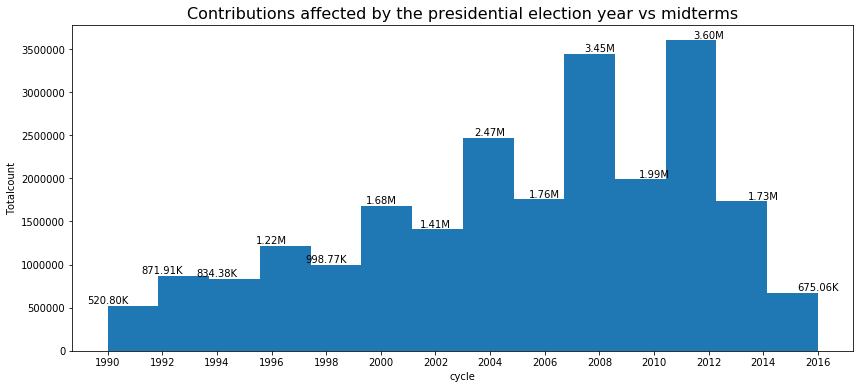

In [182]:
plot_hisgram_pd(contributions_by_year_Unearmarked_Con, 
                "Contributions affected by the presidential election year vs midterms", "cycle", "Totalcount")

### Getting tthe total counts for each election cycle that has the intermediary party's earmarked contributions.

In [186]:
# using 100 partitions
contributions_by_year_Earmarked_Con = get_Totalcount_cycle(df_ind_Earmarked_Con,100)

+-----+----------+
|cycle|Totalcount|
+-----+----------+
|1990 |9497      |
|1992 |16312     |
|1994 |14071     |
|1996 |22641     |
|1998 |23483     |
|2000 |35536     |
|2002 |34626     |
|2004 |54443     |
|2006 |83826     |
|2008 |134267    |
|2010 |148366    |
|2012 |234829    |
|2014 |282832    |
|2016 |124337    |
+-----+----------+

Execution Time: 0.12819170951843262 seconds


In [187]:
# using 200 partitions
contributions_by_year_Earmarked_Con = get_Totalcount_cycle(df_ind_Earmarked_Con,200)

+-----+----------+
|cycle|Totalcount|
+-----+----------+
|1990 |9497      |
|1992 |16312     |
|1994 |14071     |
|1996 |22641     |
|1998 |23483     |
|2000 |35536     |
|2002 |34626     |
|2004 |54443     |
|2006 |83826     |
|2008 |134267    |
|2010 |148366    |
|2012 |234829    |
|2014 |282832    |
|2016 |124337    |
+-----+----------+

Execution Time: 0.021108388900756836 seconds


###  <img src="./images/Dataset-Exploration.png" align='left' width='50'> Plotting tthe total counts for each election cycle that has the intermediary party's earmarked contributions.

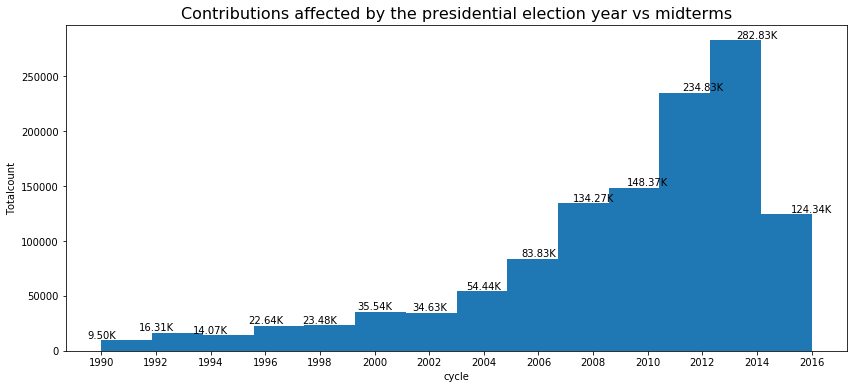

In [164]:
plot_hisgram_pd(contributions_by_year_Earmarked_Con, 
                "Contributions affected by the presidential election year vs midterms", "cycle", "Totalcount")

## <img src="./images/Question.png" align='left' width='50'>  How does a donor's industry or ideology affect individual contributions?

The 'get_Totalamounts_BybroadcastjoinTwoTab' uses broadcast joins between two tables to return the total amounts for each column of the broadcast table. 

In [33]:

def get_Totalamounts_BybroadcastjoinTwoTab(df_smaller, df_larger, name_col_df_smaller, name_col_df_larger):
    # broadcast is used on 'df_politicians' beacause it is the smallest DataFrame. 
    # This will optimize the join operation by sending the smaller DataFrame to all the worker nodes. 
    df_broadcast = broadcast(df_smaller)
    start_time = time.time()

    # Perform the join operation
    joined_df = df_larger.join(df_broadcast, 
                                          df_larger[name_col_df_larger] == df_broadcast[name_col_df_smaller],
                                          how="inner")
    # collect the first 100 rows from the joined DataFrame
    #result = joined_df.limit(100).collect()
    end_time = time.time()

    # Calculate the execution time
    execution_time = end_time - start_time
    print("Execution Time for broadcast join:", execution_time, "seconds")
    #------------------------------------------------------------------------
    print("Getting total amounts by groupBy ......")
    df_res_Totalamounts  = get_Totalamounts_groupBy(joined_df, name_col_df_smaller)
    return df_res_Totalamounts

### Getting the total amounts for the donor's industry or ideology in individual contributions that don't have the intermediary party's earmarked contributions.

In [44]:
df_totalamounts_ind_Unearmarked_Con = get_Totalamounts_BybroadcastjoinTwoTab(df_industry_codes, 
                                                                           df_ind_Unearmarked_Con, 
                                                                           "category_code", 
                                                                           "real_code")

Execution Time for broadcast join: 0.015861034393310547 seconds
Getting total amounts by groupBy ......
+-------------+-------------+
|category_code|TotalAmount  |
+-------------+-------------+
|Y4000        |2.470164848E9|
|X1200        |2.004489937E9|
|K1000        |1.441010332E9|
|F2100        |6.70385081E8 |
|Y2000        |6.41408797E8 |
|Y1000        |5.33780062E8 |
|F4000        |3.70575174E8 |
|F4100        |3.51202446E8 |
|G0000        |3.48533911E8 |
|H1100        |3.4819617E8  |
|F7000        |3.3573944E8  |
|Z9100        |3.15307072E8 |
|K2000        |3.08231863E8 |
|J1200        |2.94386623E8 |
|F2600        |2.89986423E8 |
|J1100        |2.78930945E8 |
|H5100        |2.40169294E8 |
|G5200        |2.3368917E8  |
|H1130        |2.27599964E8 |
|F1100        |2.13257682E8 |
+-------------+-------------+
only showing top 20 rows

Execution Time: 0.11392354965209961 seconds


### <img src="./images/Dataset-Exploration.png" align='left' width='50'>  plotting the total amounts for the donor's industry or ideology in individual contributions that don't have the intermediary party's earmarked contributions.

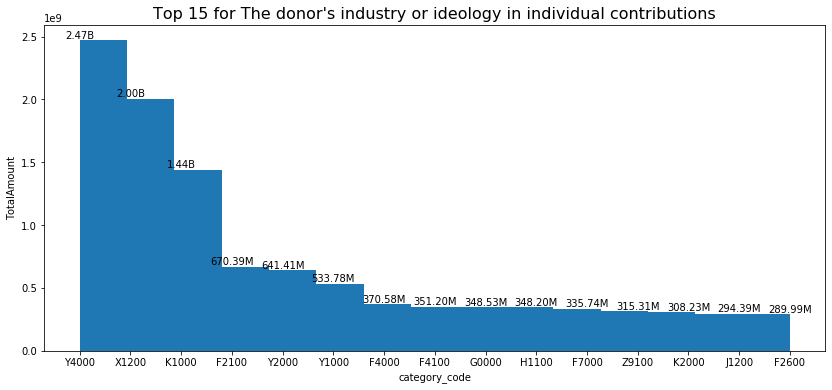

In [64]:
df_15Toptotalamounts_ind_Unearmarked_Con = df_totalamounts_ind_Unearmarked_Con.limit(15)
plot_hisgram_pd(df_15Toptotalamounts_ind_Unearmarked_Con, 
                "Top 15 for The donor's industry or ideology in individual contributions", "category_code", "TotalAmount")

### Getting the total amounts for the donor's industry or ideology in individual contributions that have the intermediary party's earmarked contributions.

In [65]:
df_totalamounts_ind_Earmarked_Con = get_Totalamounts_BybroadcastjoinTwoTab(df_industry_codes, 
                                                                           df_ind_Earmarked_Con, 
                                                                           "category_code", 
                                                                           "real_code")

Execution Time for broadcast join: 0.008783340454101562 seconds
Getting total amounts by groupBy ......
+-------------+------------+
|category_code|TotalAmount |
+-------------+------------+
|Z9000        |9.20710112E8|
|Z9999        |7.29005408E8|
|Z9500        |4.69603999E8|
|J1200        |4.9694982E7 |
|Y4000        |2.9975868E7 |
|J7400        |2.7890867E7 |
|J1100        |2.1588231E7 |
|X1200        |2.0422564E7 |
|K1000        |1.8206478E7 |
|Y1000        |9915297.0   |
|J5100        |8699406.0   |
|Z9600        |8256512.0   |
|H5100        |6855666.0   |
|K2000        |5736666.0   |
|J9000        |5461741.0   |
|JE300        |5397436.0   |
|J2200        |3642298.0   |
|F2100        |3493026.0   |
|G0000        |3101809.0   |
|G5200        |2816166.0   |
+-------------+------------+
only showing top 20 rows

Execution Time: 0.08104300498962402 seconds


### <img src="./images/Dataset-Exploration.png" align='left' width='50'>  plotting the total amounts for the donor's industry or ideology in individual contributions that have the intermediary party's earmarked contributions.

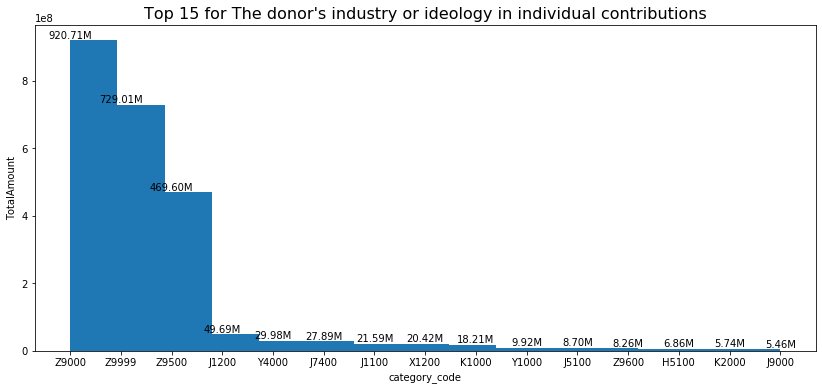

In [66]:
df_15Toptotalamounts_ind_Earmarked_Con = df_totalamounts_ind_Earmarked_Con.limit(15)
plot_hisgram_pd(df_15Toptotalamounts_ind_Earmarked_Con, 
                "Top 15 for The donor's industry or ideology in individual contributions", "category_code", "TotalAmount")